In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import sqlite3

In [2]:
database = "Data/database.sqlite"
con = sqlite3.connect(database)
df = pd.read_sql("select * from consumer_complaints", con)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555957 entries, 0 to 555956
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   date_received                 555957 non-null  object
 1   product                       555957 non-null  object
 2   sub_product                   397635 non-null  object
 3   issue                         555957 non-null  object
 4   sub_issue                     212622 non-null  object
 5   consumer_complaint_narrative  66806 non-null   object
 6   company_public_response       85124 non-null   object
 7   company                       555957 non-null  object
 8   state                         551070 non-null  object
 9   zipcode                       551452 non-null  object
 10  tags                          77959 non-null   object
 11  consumer_consent_provided     123458 non-null  object
 12  submitted_via                 555957 non-null  object
 13 

In [4]:
data = df[['product', 'consumer_complaint_narrative']]

In [5]:
data = data.dropna()

In [6]:
data

,product,consumer_complaint_narrative
190126,Debt collection,XXXX has claimed I owe them {$27.00} for XXXX ...
190135,Consumer Loan,Due to inconsistencies in the amount owed that...
190155,Mortgage,In XX/XX/XXXX my wages that I earned at my job...
190207,Mortgage,I have an open and current mortgage with Chase...
190208,Mortgage,XXXX was submitted XX/XX/XXXX. At the time I s...
...,...,...
553084,Credit reporting,"XXXX XXXX is reporting incorrectly, payments h..."
553085,Credit reporting,Reflecting incorrect payment status. Have been...
553086,Payday loan,I have been paying {$180.00} a month through d...
553090,Mortgage,I recently became aware that Amerisave Mortgag...


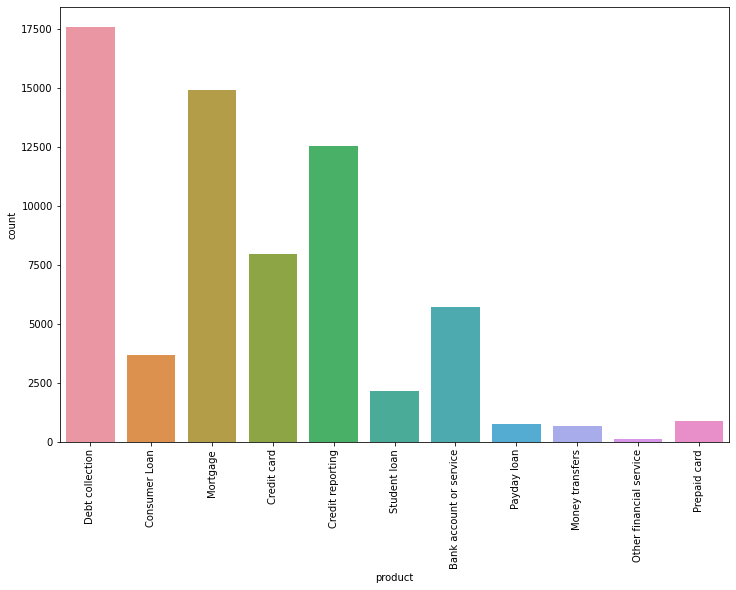

In [7]:
plt.figure(figsize=(12,8))
sns.countplot(x=data['product'])
plt.xticks(rotation=90);

In [8]:
category = pd.DataFrame()
category['product'] = data["product"]
category['category'] = data["product"].factorize()[0]

In [9]:
category['narrative'] = data['consumer_complaint_narrative'].str.replace("X"," ")

In [10]:
cat_id = category.drop_duplicates().sort_values("category")

In [11]:
cat_id

,product,category,narrative
190126,Debt collection,0,has claimed I owe them {$27.00} for ...
281327,Debt collection,0,"HELLO, I HAVE NEVER HEARD FROM THIS COMPANY, N..."
281317,Debt collection,0,My husband and I relocated to from i...
281283,Debt collection,0,I am & have been paying for years a month...
281282,Debt collection,0,I filed a TILA complaint in Fl. state court in...
...,...,...,...
517339,Prepaid card,10,On was the last day I could use my c...
521286,Prepaid card,10,I am a customer with rush card / meta bank and...
513742,Prepaid card,10,"Hello, I am an unfortunate customer of Rushcar..."
517358,Prepaid card,10,I ordered a replacement card from the rush car...


In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [13]:
token = Tokenizer()
token.fit_on_texts(data['consumer_complaint_narrative'])
vocabs = token.index_word
vocabs_len = len(token.word_index) + 1

In [14]:
text = token.texts_to_sequences(category['narrative'])

In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [16]:
X = pad_sequences(text)

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
 X_train, X_test, y_train, y_test = train_test_split(X, category['category'], test_size=0.1, random_state=101)

Model Building

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, Embedding

In [20]:
model = Sequential()
model.add(Embedding(vocabs_len, 300)) 
model.add(Conv1D(kernel_size=64, filters=8, activation='relu'))

model.add(MaxPooling1D(2))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(16, activation='relu'))

model.add(GlobalMaxPooling1D())

model.add(Dense(len(category['category']), activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         16553400  
                                                                 
 conv1d (Conv1D)             (None, None, 8)           153608    
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 8)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, None, 8)           0         
                                                                 
 dense (Dense)               (None, None, 32)          288       
                                                                 
 dropout_1 (Dropout)         (None, None, 32)          0         
                                                        

In [21]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs = 5, validation_data=(X_test, y_test))

Epoch 1/5
1879/1879 [==============================] - 1643s 873ms/step - loss: 1.5679 - accuracy: 0.4328 - val_loss: 2.5262 - val_accuracy: 0.7388
Epoch 2/5
1879/1879 [==============================] - 1615s 859ms/step - loss: 0.7688 - accuracy: 0.7635 - val_loss: 1.7177 - val_accuracy: 0.7821
Epoch 3/5
 883/1879 [=============>................] - ETA: 22:15 - loss: 0.6176 - accuracy: 0.8159